<a href="https://colab.research.google.com/github/Chihiro-n/stockmodel/blob/master/Check_Sinwave_LSTM_Stock_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NNで株価を予測モデルを作成する
rev2:入力データを一次元に限定

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# LSTMモデルを組む

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%pwd

'/content'

In [5]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [6]:
%ls

 Check_Sinwave_LSTM_Stock_Classify.ipynb
'Colaboratory へようこそ のコピー'
 data/
 data_dir/
 DogCat.ipynb
 kaggleデータinputの方法DogCat.ipynb
 keras_ssd_hands-on/
 LSTM_changed_dataset.ipynb
'LSTM_Stock_Classify (1).ipynb'
 LSTM_Stock_Classify.ipynb
 net.ckpt
 prophet/
'PyTorch実践入門ハンズオンセミナー配布用 のコピー'
 RNN_shapeCheak.ipynb
 RNN_sin_pred.ipynb
 sampleSubmission.csv
 torch_tuto_CFIA10.ipynb
 Youtube_Analysis_1.ipynb


# GPUセットのためのおまじない

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# sinwave データセット作成

In [8]:
import math

def mkDataSet(data_size, data_length=50, freq=60.):
    """
    params
      data_size : データセットのサイズ
      data_length : 各データの時系列長
      freq : 周波数
    returns
      train_x : トレーニングデータ（t=1,2,...,size-1の値)
      train_t : トレーニングデータのラベル（t=sizeの値）
    """
    train_x = []
    train_t = []

    for offset in range(data_size):
        train_x.append([[math.sin(2 * math.pi * (offset + i) / freq)] for i in range(data_length)])
        train_t.append([math.sin(2 * math.pi * (offset + data_length) / freq)])

    return train_x, train_t

In [9]:
training_size = 100 
batch_size = 10

train_input , train_t = mkDataSet(training_size)

### numpyに変更し、サイズもチェック

In [10]:
np_train_input = np.array(train_input)
np_train_input = np_train_input.astype(np.float32)  ### float型に変更しておかないと、modelに入力する際にerrorが出る　※doubleはNG

print(np_train_input.shape)

np_train_input


(100, 50, 1)


array([[[ 0.        ],
        [ 0.10452846],
        [ 0.20791169],
        ...,
        [-0.9781476 ],
        [-0.95105654],
        [-0.9135454 ]],

       [[ 0.10452846],
        [ 0.20791169],
        [ 0.309017  ],
        ...,
        [-0.95105654],
        [-0.9135454 ],
        [-0.8660254 ]],

       [[ 0.20791169],
        [ 0.309017  ],
        [ 0.40673664],
        ...,
        [-0.9135454 ],
        [-0.8660254 ],
        [-0.809017  ]],

       ...,

       [[-0.6691306 ],
        [-0.7431448 ],
        [-0.809017  ],
        ...,
        [ 0.58778524],
        [ 0.5       ],
        [ 0.40673664]],

       [[-0.7431448 ],
        [-0.809017  ],
        [-0.8660254 ],
        ...,
        [ 0.5       ],
        [ 0.40673664],
        [ 0.309017  ]],

       [[-0.809017  ],
        [-0.8660254 ],
        [-0.9135454 ],
        ...,
        [ 0.40673664],
        [ 0.309017  ],
        [ 0.20791169]]], dtype=float32)

# labelデータも numpyに変更しておく
labalはonehot vectorなので、(3366,1,4)になるはず -> X ※pytorchのクロスエントロピーロスはエントロピーロスはonehotvectorに対応しておらずクラスラベルにする

In [11]:
np_train_t = np.array(train_t)

np_train_label = np_train_t.astype(np.float32)
print(np_train_label)
print(np_train_label.shape)


[[-8.66025388e-01]
 [-8.09017003e-01]
 [-7.43144810e-01]
 [-6.69130623e-01]
 [-5.87785244e-01]
 [-5.00000000e-01]
 [-4.06736642e-01]
 [-3.09017003e-01]
 [-2.07911685e-01]
 [-1.04528464e-01]
 [-1.13310774e-15]
 [ 1.04528464e-01]
 [ 2.07911685e-01]
 [ 3.09017003e-01]
 [ 4.06736642e-01]
 [ 5.00000000e-01]
 [ 5.87785244e-01]
 [ 6.69130623e-01]
 [ 7.43144810e-01]
 [ 8.09017003e-01]
 [ 8.66025388e-01]
 [ 9.13545430e-01]
 [ 9.51056540e-01]
 [ 9.78147626e-01]
 [ 9.94521916e-01]
 [ 1.00000000e+00]
 [ 9.94521916e-01]
 [ 9.78147626e-01]
 [ 9.51056540e-01]
 [ 9.13545430e-01]
 [ 8.66025388e-01]
 [ 8.09017003e-01]
 [ 7.43144810e-01]
 [ 6.69130623e-01]
 [ 5.87785244e-01]
 [ 5.00000000e-01]
 [ 4.06736642e-01]
 [ 3.09017003e-01]
 [ 2.07911685e-01]
 [ 1.04528464e-01]
 [ 3.67394029e-16]
 [-1.04528464e-01]
 [-2.07911685e-01]
 [-3.09017003e-01]
 [-4.06736642e-01]
 [-5.00000000e-01]
 [-5.87785244e-01]
 [-6.69130623e-01]
 [-7.43144810e-01]
 [-8.09017003e-01]
 [-8.66025388e-01]
 [-9.13545430e-01]
 [-9.5105654

## Shapeを変更する、 二重リストの型へ


In [12]:
np_train_label = np_train_label.reshape(-1,1)

In [13]:
print(np_train_label.shape)
print(np_train_label)


(100, 1)
[[-8.66025388e-01]
 [-8.09017003e-01]
 [-7.43144810e-01]
 [-6.69130623e-01]
 [-5.87785244e-01]
 [-5.00000000e-01]
 [-4.06736642e-01]
 [-3.09017003e-01]
 [-2.07911685e-01]
 [-1.04528464e-01]
 [-1.13310774e-15]
 [ 1.04528464e-01]
 [ 2.07911685e-01]
 [ 3.09017003e-01]
 [ 4.06736642e-01]
 [ 5.00000000e-01]
 [ 5.87785244e-01]
 [ 6.69130623e-01]
 [ 7.43144810e-01]
 [ 8.09017003e-01]
 [ 8.66025388e-01]
 [ 9.13545430e-01]
 [ 9.51056540e-01]
 [ 9.78147626e-01]
 [ 9.94521916e-01]
 [ 1.00000000e+00]
 [ 9.94521916e-01]
 [ 9.78147626e-01]
 [ 9.51056540e-01]
 [ 9.13545430e-01]
 [ 8.66025388e-01]
 [ 8.09017003e-01]
 [ 7.43144810e-01]
 [ 6.69130623e-01]
 [ 5.87785244e-01]
 [ 5.00000000e-01]
 [ 4.06736642e-01]
 [ 3.09017003e-01]
 [ 2.07911685e-01]
 [ 1.04528464e-01]
 [ 3.67394029e-16]
 [-1.04528464e-01]
 [-2.07911685e-01]
 [-3.09017003e-01]
 [-4.06736642e-01]
 [-5.00000000e-01]
 [-5.87785244e-01]
 [-6.69130623e-01]
 [-7.43144810e-01]
 [-8.09017003e-01]
 [-8.66025388e-01]
 [-9.13545430e-01]
 [-

## TrainとTestで分割する

In [14]:
X_train, y_train, X_test, y_test= [], [], [], []


all_length = len(np_train_label)
train_length = int(all_length*0.9)

### 訓練用データセットを作成するループ
X_train = np_train_input[:train_length]
y_train = np_train_label[:train_length]

### テスト用データセットを作成するループ
X_test = np_train_input[train_length:]
y_test = np_train_label[train_length:]



In [15]:
all_length

100

In [16]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)


(90, 50, 1)
(90, 1)
(10, 50, 1)
(10, 1)


In [17]:
y_train

array([[-8.66025388e-01],
       [-8.09017003e-01],
       [-7.43144810e-01],
       [-6.69130623e-01],
       [-5.87785244e-01],
       [-5.00000000e-01],
       [-4.06736642e-01],
       [-3.09017003e-01],
       [-2.07911685e-01],
       [-1.04528464e-01],
       [-1.13310774e-15],
       [ 1.04528464e-01],
       [ 2.07911685e-01],
       [ 3.09017003e-01],
       [ 4.06736642e-01],
       [ 5.00000000e-01],
       [ 5.87785244e-01],
       [ 6.69130623e-01],
       [ 7.43144810e-01],
       [ 8.09017003e-01],
       [ 8.66025388e-01],
       [ 9.13545430e-01],
       [ 9.51056540e-01],
       [ 9.78147626e-01],
       [ 9.94521916e-01],
       [ 1.00000000e+00],
       [ 9.94521916e-01],
       [ 9.78147626e-01],
       [ 9.51056540e-01],
       [ 9.13545430e-01],
       [ 8.66025388e-01],
       [ 8.09017003e-01],
       [ 7.43144810e-01],
       [ 6.69130623e-01],
       [ 5.87785244e-01],
       [ 5.00000000e-01],
       [ 4.06736642e-01],
       [ 3.09017003e-01],
       [ 2.0

In [18]:
def mkRandomBatch(train_x, train_t, batch_size=10):
    """
    train_x, train_tを受け取ってbatch_x, batch_tを返す。
    """
    batch_x = []
    batch_t = []

    for _ in range(batch_size):
        idx = np.random.randint(0, len(train_x) - 1)
        batch_x.append(train_x[idx])
        batch_t.append(train_t[idx])
    
    return torch.tensor(batch_x), torch.tensor(batch_t)

In [19]:
 #torch_train_x , torch_train_y = mkRandomBatch(X_train,y_train)

# モデルの構築
* input 層
* middle 層
* output 層

In [20]:
import torch
import torch.nn as nn


class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()
        
        self.lstm = nn.LSTM(input_size = inputDim,
                            hidden_size = hiddenDim,
                            batch_first = True)
                           
        self.lstm_output_layer = nn.Linear(hiddenDim, outputDim)
        #self.sigmoid_out = nn.Linear(outputDim, 4)    # labelは one hotベクトルなので outputを4クラスに分けられるようにする
        #self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, inputs, hidden0=None):
        #print(inputs) 　　　　# このinputsには1batchが入る。サイズが4なら 4 ,50, 1 
        output, (hidden, cell) = self.lstm(inputs, hidden0) #LSTM層
        output = self.lstm_output_layer(output[:, -1, :]) #全結合層
        #output = self.sigmoid_out(output)
        return output


In [21]:
model = Predictor(1,5,1)    # inputの次元は? 株価onlyだから1次元となるのか、それとも時間を5個分とってくるから 5次元？？
model

Predictor(
  (lstm): LSTM(1, 5, batch_first=True)
  (lstm_output_layer): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
# 損失関数
criterion = nn.MSELoss()      ### 損失化関数は二乗誤差を設定。　回帰モデルなのでOK
#criterion = nn.CrossEntropyLoss() #ソフトマックス交差エントロピー

# 最適化関数
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)     ### lrは学習率

# dataloaderを使った学習

In [23]:
ls_loss = []
model.train()


for epoch in range(100):
    
    model.train()
    for i in range(int(training_size / batch_size)):
        optimizer.zero_grad()

        data, label = mkRandomBatch(X_train, y_train, batch_size)

        #X = torch.tensor(X_train[i])
        #label = torch.tensor(y_train[i])

        #X_torch = X.to(device)
        #label_torch = label.to(device)



       # print("X shape ",X_torch.shape)
       # print("label shape",label_torch.shape)
       # print("label",label_torch)

        # 勾配の初期化
        optimizer.zero_grad()     
        
        y_pred = model( data )          ### ニューラルネットで計算したoutputを保存
        
        #print("y_pred : ",y_pred)
        #print("y_pred shape: ",y_pred.shape)
        #print("label_torch" ,label_torch)
        #print("label_torch shape" ,label_torch.shape)

        loss = criterion(y_pred, label) ###教師データとoutputから損失関数を計算
        #break

        # バッチごとのロスを記録する
        ls_loss.append(loss)
        
        # 勾配の計算
        loss.backward()           ### 損失関数を微分 = 勾配の計算
        
        # パラメータの更新
        optimizer.step()           
        
        #print('*** by optimizer.step()')
    

### ロスの確認 dataloader

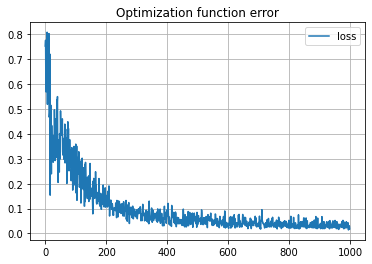

In [24]:
plt.figure()
plt.plot(ls_loss,label="loss")
plt.title('Optimization function error') # 最適化関数の誤差
plt.legend()
plt.grid()

## できあがったmodelでテストを行ってみる

In [25]:
testset = Dataset( X_test , y_test )
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size = 1, shuffle=True)

TypeError: ignored

In [ ]:
dataiter = iter(dataloader)

X, labal = dataiter.next()

In [ ]:

y_testresult = []
model.eval()
#t = np.arange(50, 58)



for i, (X, label) in enumerate(dataloader):

    #print("@@@@@@@@@@@@", i)
    
    #print(X)
    optimizer.zero_grad()
    
    y = model(X)
    l = label
    
    #print("label",label)
    #print(y)
    
    y = y.to('cpu').detach().numpy().copy()
    l = l.to('cpu').detach().numpy().copy()
    
    y_flat = y.flatten()
    l_flat = l.flatten()
    
  
    plt.plot(t,y_flat, marker = 'o')
    plt.plot(t,l_flat, marker = 'x')
    plt.show()


In [ ]:
y = model(X)

In [ ]:
print(X)
print(y)
print(l)